# EDA

- This notebook utilizes the `tweets_classified_US` dataframe that was created in the **Project_04_US_NMF** notebook.
- The following tasks will be performed before exploratory data analysis is executed:
    - Insert month and year columns into `tweets_classified_US`
    - Insert region user region column into `tweets_classified_US`
- The following EDA will be performed with the updated `tweets_classified_US` dataframe:
    - Investigate the number of believer and denier tweets by region
    - Investigate how "consistent" users are, i.e. do they only tweet believer or denier tweets, or is there a mix?
    - Investigate the total number of believer users vs denier users
    - Investigate the total number of users by region
    - Investigate the number of believer and denier users by region

In [137]:
import pickle
import re
import string
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.precision', 3)

import nltk

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# gensim
from gensim import corpora, models, similarities, matutils

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load in Dataframes

In [2]:
with open('Data/tweets_classified_US.pkl','rb') as read_file:
    tweets_classified_US = pickle.load(read_file)

In [3]:
with open('Data/tweets_classified_Other.pkl','rb') as read_file:
    tweets_classified_Other = pickle.load(read_file)

In [4]:
with open('Data/tweets_classified_logit.pkl','rb') as read_file:
    tweets_classified = pickle.load(read_file)

# Convert date columns to datetime and insert month and year columns

In [5]:
date = pd.to_datetime(tweets_classified_US['created_at'], format='%m/%d/%Y')

In [6]:
tweets_classified_US.insert(1, column = "Month", value = date.dt.month)
tweets_classified_US.insert(2, column = "Year", value = date.dt.year)

---

In [7]:
tweets_classified_US['User_Location'].isna().value_counts()

False    1235350
Name: User_Location, dtype: int64

In [8]:
tweets_classified_Other['User_Location'].isna().value_counts()

False    2024011
True      966055
Name: User_Location, dtype: int64

In [9]:
tweets_classified_Other = tweets_classified_Other[tweets_classified_Other['User_Location'].isna() == False]


In [10]:
tweets_classified_Other['User_Location'].isna().value_counts()

False    2024011
Name: User_Location, dtype: int64

In [11]:
# with open('tweets_classified_Other2.pkl', 'wb') as to_write:
#     pickle.dump(tweets_classified_Other, to_write)

In [12]:
# tweets_sentiment_US = tweets_classified_US.groupby('Believer_or_Denier')['Tweet_Sentiment'].value_counts()

In [14]:
# tweets_sentiment_Other = tweets_classified_Other.groupby('Believer_or_Denier')['Tweet_Sentiment'].value_counts()


---

# Determine US Region for Each Tweet

- Based on `region_dict`, assign region to each tweet in `tweets_classified_US`

In [18]:
region_dict = {
                'Northeast': ['Maryland', 'MD', 'Delaware', 'DE', 'District of Columbia', 'DC', 'New Jersey', 'NJ', 'Pennsylvania', 'PA', 'New York', 'NY', 'Massachusetts', 'MA', 
                              'Connecticut', 'CT', 'Rhode Island', 'RI', 'New Hampshire', 'NH', 'Vermont', 'VT', 'Maine', 'ME', 'Virginia', 'VA'],
               'West Coast': ['California', 'CA', 'Oregon', 'OR', 'Washington', 'WA'],
                  'Rockies': ['Nevada', 'NV', 'Utah', 'UT', 'Idaho', 'ID', 'Montana', 'MT', 'Wyoming', 'WY', 'Colorado', 'CO'],
                'Southwest': ['Arizona', 'AZ', 'New Mexico', 'NM'],
                  'Midwest': ['Missouri', 'MO', 'Kansas', 'KS', 'North Dakota', 'ND', 'South Dakota', 'SD', 'Nebraska', 'NE', 'Minnesota', 'MN', 'Iowa', 'IA', 'Wisconsin', 'WI', 
                              'Illinois', 'IL', 'Indiana', 'IN', 'Michigan', 'MI', 'Ohio', 'OH'],
                    'South': ['Texas', 'TX', 'Oklahoma', 'OK', 'Arkansas', 'AR', 'Louisiana', 'LA', 'Mississippi', 'MS', 'Alabama', 'AL', 'Georgia', 'GA', 'Florida', 'FL', 
                              'Kentucky', 'KY', 'Tennessee', 'TN', 'North Carolina', 'NC', 'South Carolina', 'SC', 'West Virginia', 'WV'],
                   'Hawaii': ['Hawaii', 'HI'],
                   'Alaska': ['Alaska', 'AK'],
                       'US': ['US', 'USA', 'United States']
              }

In [59]:
regions_list = []
index_list = [-2,-1]

for index, rows in tweets_classified_US['User_Location'].iteritems():
    for key, value in region_dict.items():
        for i in value:
            if i in rows:
                index_list.append(index)
                if index_list[-1] != index_list[-2]: # prevents duplicates, as User_Location sometimes lists multiple locations
                    regions_list.append([index, key])
                    break

In [60]:
len(regions_list)

1235350

## Insert "User_Region" column into `tweets_classified_US`

In [66]:
regions_ind = [ind[0] for ind in regions_list]
regions_loc = [loc[1] for loc in regions_list]
regions_series = pd.Series(regions_loc, index = regions_ind)

In [30]:
regions_series

0           Northeast
2          West Coast
3               South
6          West Coast
9             Rockies
              ...    
4225391       Rockies
4225394     Northeast
4225399            US
4225406     Northeast
4225408       Rockies
Length: 1235350, dtype: object

In [71]:
tweets_classified_US.insert(20, column = 'User_Region', value = regions_series)

In [72]:
tweets_classified_US

,created_at,Month,Year,favorite_count,Believer_or_Denier,Tweet_Sentiment,preprocessed_text,full_text,geo,retweet_count,Hashtags_List,User_Name,User_Screen_Name,User_Status_Count,User_Followers_Count,User_Friends_Count,User_Verified_Status,User_Account_Start_Date,User_Years_Active,User_Location,User_Region,Tweet_Location,Tweet_Location_Country,Tweet_Location_Country_Code,Merge_Index,US_or_Other
0,2017-09-21,9,2017,0,0.0,neutral,"[all, hurricane, victims, should, sue, trump, ...","All #Hurricane victims should sue #Trump, #Pru...",NaN,0,"[hurricane, trump, pruitt, fossilfuel, climate...",Soledad Haren,Soledad_Haren,11511,317,260,False,2008-11-16,8.8,"New York, LA, Miami, Houston",Northeast,NaN,NaN,NaN,0,US
3,2017-09-21,9,2017,0,1.0,neutral,"[san, francisco, sues, oil, companies, over, c...",San Francisco sues oil companies over #climate...,NaN,0,[climate],A&R Solar,aandrsolar,3088,975,744,False,2010-07-01,7.2,"Seattle, WA",West Coast,NaN,NaN,NaN,3,US
6,2017-09-21,9,2017,0,0.0,negative,"[is, the, hurricane, season, worse, than, usua...",Is the 2017 #hurricane season worse than usual...,NaN,0,"[hurricane, climatechange, weather, environmen...",YouthBuild USA Green,YB_Green,2471,882,1042,False,2010-12-15,6.8,"Somerville, MA",Northeast,NaN,NaN,NaN,6,US
9,2017-09-21,9,2017,0,0.0,positive,"[trudeau, is, transitioning, to, climate, chan...",Trudeau is transitioning to climate change dis...,NaN,1,"[unga, j711]",brad schaible,gobrado,167,60,194,False,2012-07-01,5.2,"Cary, NC",South,NaN,NaN,NaN,9,US
17,2017-09-21,9,2017,1,0.0,neutral,"[these, vermont, based, companies, want, to, c...",These Vermont-based companies want to conquer ...,NaN,3,[],Seven Days,sevendaysvt,30670,49806,1913,True,2007-06-05,10.3,"Burlington, Vermont",Northeast,NaN,NaN,NaN,17,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225408,2019-05-19,5,2019,0,0.0,positive,"[the, latest, yhwh, holy, scriptures, thanks, ...",The latest YHWH HOLY SCRIPTURES! https://t.co/...,NaN,0,"[environment, climatechange]",CarrieGaard,CarrieGaard,93556,1157,176,False,2009-06-21,9.9,��GL��BAL��,South,NaN,NaN,NaN,4225408,US
4225409,2019-05-19,5,2019,0,0.0,neutral,"[all, left]",All 800 left. https://t.co/Dr5aROHJzb,NaN,0,[],Simarilian,simarilian,75770,1137,1983,False,2008-08-27,10.7,Oregon,West Coast,NaN,NaN,NaN,4225409,US
4225410,2019-05-19,5,2019,1,0.0,positive,"[look, at, this, clever, animation, showing, t...","Look at this clever animation, showing the tem...",NaN,0,[],Claudio Alatorre,ClaudioAlatorre,10,86,41,False,2011-12-10,7.4,"Washington, DC",Northeast,NaN,NaN,NaN,4225410,US
4225411,2019-05-19,5,2019,2,0.0,positive,"[climate, change, why, the, australian, labor,...",Climate Change: Why The Australian Labor Party...,NaN,3,[],Iowa Climate ����,IowaClimate,36554,1726,1250,False,2016-12-30,2.4,"Iowa, USA",Midwest,NaN,NaN,NaN,4225411,US


In [75]:
# with open('Data/tweets_classified_US_region.pkl', 'wb') as to_write:
#     pickle.dump(tweets_classified_US, to_write)

# Dig into Data

## Number of Believer/Denier Tweets by Region

In [73]:
tweets_classified_region = tweets_classified_US.groupby('Believer_or_Denier')['User_Region'].value_counts()

In [74]:
tweets_classified_region

Believer_or_Denier  User_Region
0.0                 Northeast      346780
                    West Coast     211587
                    South          193616
                    Midwest        134864
                    US             109221
                    Rockies         55625
                    Southwest       24957
                    Hawaii           5181
                    Alaska           3582
1.0                 South           37237
                    Northeast       31710
                    US              24384
                    West Coast      24036
                    Midwest         20109
                    Rockies          7391
                    Southwest        4064
                    Hawaii            519
                    Alaska            487
Name: User_Region, dtype: int64

## User Believer/Denier Consistency

In [76]:
tweets_classified_user_const = tweets_classified_US.groupby(['User_Name', 'User_Region']).agg({'full_text':'count', 'Believer_or_Denier': 'sum'}).reset_index()
tweets_classified_user_const['consistency'] = tweets_classified_user_const['Believer_or_Denier']/tweets_classified_user_const['full_text']

In [93]:
tweets_classified_user_const.head(20)

,User_Name,User_Region,full_text,Believer_or_Denier,consistency
0,,Southwest,2,2.0,1.000
1,Corona,Northeast,1,0.0,0.000
2,Watcher Underground,Midwest,5,2.0,0.400
3,ozzie Johnson,Midwest,1,0.0,0.000
4,!,Midwest,1,0.0,0.000
5,!,Northeast,1,0.0,0.000
6,!,Southwest,1,0.0,0.000
7,! deactivated,Northeast,2,0.0,0.000
8,! jacqueline !,South,1,0.0,0.000
9,! xzaVier ¡,Midwest,1,1.0,1.000


(array([287357.,   4906.,   6623.,   6110.,   1877.,  12725.,   2775.,
          1216.,    778.,  31414.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

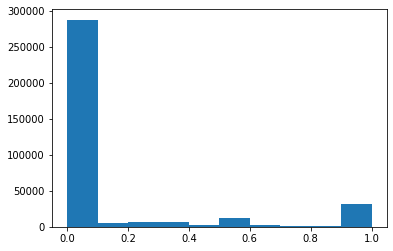

In [138]:
plt.hist(tweets_classified_user_const.consistency.values)

### Total Number of Believer vs Denier Users

In [96]:
num_believers = len(tweets_classified_user_const[tweets_classified_user_const.consistency < 0.5])
num_deniers = len(tweets_classified_user_const[tweets_classified_user_const.consistency >= 0.5])

In [100]:
print('Number of believer users:', num_believers)
print('Number of denier users:', num_deniers)
print('Percent denier users:', round(100*num_deniers/(num_believers + num_deniers), 1), '%')

Number of believer users: 306873
Number of denier users: 48908
Percent denier users: 13.7 %


## Number of Users by Region

### Total by Region

In [103]:
tweets_classified_user_believers = tweets_classified_user_const.groupby('User_Region').agg({'User_Name':'count'}).reset_index()

In [104]:
tweets_classified_user_region

,User_Region,User_Name
0,Alaska,1219
1,Hawaii,1471
2,Midwest,54572
3,Northeast,100627
4,Rockies,16915
5,South,77262
6,Southwest,8520
7,US,31103
8,West Coast,64092


### Believer vs Denier by Region

In [108]:
tweets_classified_user_believers = tweets_classified_user_const[tweets_classified_user_const.consistency < 0.5]
tweets_classified_user_deniers = tweets_classified_user_const[tweets_classified_user_const.consistency >= 0.5]

In [114]:
tweets_classified_region_believers = tweets_classified_user_believers.groupby('User_Region').agg({'User_Name':'count'}).reset_index()
tweets_classified_region_deniers = tweets_classified_user_deniers.groupby('User_Region').agg({'User_Name':'count'}).reset_index()
tweets_classified_region_bd = tweets_classified_region_believers.merge(tweets_classified_region_deniers, how = 'left', on = 'User_Region')
tweets_classified_region_bd.columns = ['User_Region', 'Believer_Count', 'Denier_Count']

In [115]:
tweets_classified_region_bd

,User_Region,Believer_Count,Denier_Count
0,Alaska,1065,154
1,Hawaii,1294,177
2,Midwest,47053,7519
3,Northeast,90302,10325
4,Rockies,14585,2330
5,South,63770,13492
6,Southwest,7151,1369
7,US,24614,6489
8,West Coast,57039,7053


## User Location Dataframe

- Created for Map Chart in Tableau
    - will show distribution of believer and denier users across the US
    - needs city and state location to place data point on map

In [116]:
# users_location = tweets_classified_US.groupby(['User_Name', 'Believer_or_Denier', 'User_Location']).agg({'full_text':'count'}).reset_index()

In [117]:
users_location = tweets_classified_US.groupby(['User_Name', 'User_Location']).agg({'full_text':'count', 'Believer_or_Denier': 'sum'}).reset_index()
users_location['consistency'] = users_location['Believer_or_Denier']/users_location['full_text']

In [118]:
users_location.head(10)

,User_Name,User_Location,full_text,Believer_or_Denier,consistency
0,,"Mesa, AZ",2,2.0,1.0
1,Corona,"Manhattan, NY",1,0.0,0.0
2,Watcher Underground,"Greator Omaha, NE",5,2.0,0.4
3,ozzie Johnson,Indiana,1,0.0,0.0
4,!,Bronx NY,1,0.0,0.0
5,!,"Detroit, MI",1,0.0,0.0
6,!,"Phoenix, AZ",1,0.0,0.0
7,! deactivated,"Washington, DC",2,0.0,0.0
8,! jacqueline !,"Atlanta, GA",1,0.0,0.0
9,! xzaVier ¡,"Missouri, USA",1,1.0,1.0


In [119]:
len(users_location.User_Location)

373084

In [120]:
# Extract city and state from User_Location column

cities = []
states = []


for index, rows in users_location['User_Location'].iteritems():
    rows = rows.split(',')
    if len(rows) == 2:
        cities.append(rows[0])
        states.append(rows[1])
    else:
        cities.append(np.nan)
        states.append(np.nan)

In [121]:
cities_series = pd.Series(cities)
states_series = pd.Series(states)

In [123]:
states_series.isna().value_counts()

False    271424
True     101660
dtype: int64

In [125]:
# Add city and state columns to users_location dataframe
users_location['Cities'] = cities_series
users_location['States'] = states_series

In [126]:
users_location_slim = users_location.dropna()

In [131]:
users_location_bel = users_location_slim[users_location_slim.consistency < 0.5]
users_location_den = users_location_slim[users_location_slim.consistency >= 0.5]

In [133]:
# Check to see ratio of believers vs deniers is consistent after size of dataframe has been reduced
print('Number of believer users:', len(users_location_bel))
print('Number of denier users:', len(users_location_den))
print('Percent denier users:', round(100*len(users_location_den)/(len(users_location_bel) + len(users_location_den)), 1), '%')

Number of believer users: 235883
Number of denier users: 35541
Percent denier users: 13.1 %


### Export as CSV files

In [134]:
users_location_slim.to_csv(r'Data/users_location_slim.csv')

In [135]:
users_location_bel.to_csv(r'Data/users_location_bel.csv')

In [136]:
users_location_den.to_csv(r'Data/users_location_den.csv')